# Installing necessities

In [ ]:
# Installing necessary packages

!pip install ale-py # Package called "The Arcade Learning Environment (ALE)" which allows to develop AI agents for Atari rooms.
!pip install gymnasium # OpenAI's Gymnazium package.
!pip install --upgrade keras # Keras package.

# Setting up the environment

In [24]:
import gymnasium as gym
import ale_py
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

# Source #1: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#dqn-algorithm

# Setting up our environment via ALE and Gymnazium, initializing Keras as we use Deep Q-Learning which is an approach for training reinforcment learning agents fit for games.
# Mathplolib is also being set up here as we'll generate graph at the end as a demonstration of the learning process.

gym.register_envs(ale_py) # Registering Atari environments.
env = gym.make('ALE/Pacman-ram-v5', render_mode="rgb_array") # Picking our own environment out of all that Atari offers.

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

C:\Users\misa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [25]:
# At this point we set something called "Replay Memory". This approach stores each transition (transition=agent's interaction with the environment) which is later observed by the agent, allowing it to reuse the data.
# Moreover, this approach improves learning procedure significantly.

# Two classes are required:
  ## Transition - represents a single transition in the environment. It maps pairs (state, action) to their corresponding result (next state, reward.)
    ### State - current state of the game (current state of the board). In Tetris, which cells are empty which ones are not?, how many pieces are currently present in the environment? what kind of shapes? . . . etc.
    ### Action - helps agent to "think" and make decision that affects current game state. In Tetris it's for examples rotating currently falling piece left, right or dropping it instantly on the bottom. By choosing an action agent aims to clearing rows, avoiding building too high creating gaps . . .
    ### next_state - State after action has taken place. It represents update to grid (game borad). This provides agent with update regarding consequences of his action/s.
    ### Reward - A numerical value whcih given to the agent after each action. It serves as a reflection of how good/bad the action was or how good/bad what its impact on the game.
  ## ReplayMemory - This is a buffer that holds transition obsorved recently.


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Setting up Deep Q Learning network

In [43]:
# Q-Learning and Q-values
## In Deep Q Learning our goal is to approximate the Q-values for each action in every state. During training the neural network takes a state as an input and outputs Q-values for all possible actions (action evaluation).
## The Q-value of a state-action pair represents the expected cumulativ reward agent receives by taking this action.
## Based on those Q-values the agent performs "optimal action-selection".


# Q-Network
## In our implementation of Q-network we use something called "feed-forward network" whose primary goal is to approximate aformentioned Q-values for each possible action at certain state.
## The network takes current game state (grid state) as an input and "observes" chages and differences between current state and the previous one.
## Subsequently, network calculates and returns Q-values for each possible action where each value represent a reward that agent gets in case it decides to take this action.

## Input [curent_state] -> Q-Network -> Q(current_state, action)



class DQN(nn.Module):

    def __init__(self, n_observations, n_actions): # n_observations - represents number of features (pixels for instance) in the current state; n_actions - number of possile actions that agent can take.
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256) #128 neurons -> 256
        # Dropout randomly deactivates fraction of neurons during training phase whcih forces the network to learn more robus features and prevents overfitting (overffiting is a situation when a model learns the training data too well (memorizes it) instead of trying to "understand" general rules, principles and strategies. It memorizes patterns which is trying to "senselessly" use later)
        # self.dropout1 = nn.Dropout(0.3) #0.2 -> 0.3
        self.layer2 = nn.Linear(256, 256)
        # self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(256, n_actions) # take 128 features from the second layer as the second one takes the same amount from first one and outputs n_actions which are those Q-values.



    # The function below is called "Activation function". Activation fucntion is applied on network's output at each layer and server for introduction of non-linearity thus allow the network to learn complex patterns.
    # Varous activation functions exists in the example below ReLU is used. ReLU returns output directly in case the input is positive otherwise returns zero.

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.flatten(start_dim=1) # We need to to flatten the input s (tensor). Flattening is a process converting multidimensional input into a single vector (as expected by the first layer)
        x = F.relu(self.layer1(x)) # x represents the current state, self.layer1(x) - performs linear transformation by maping it to vector of 128 elements, the result of self.layer(1) futher serves as the input to reLU activation function, which sets negative values to zero and keeps positive ones as they are.
        # x = self.dropout1(x) # Applying dropout
        x = F.relu(self.layer2(x)) # the x here is the result of the previous operation (line above) and the operation is exactly the same, just the x is different.
        # x = self.dropout2(x)
        return self.layer3(x) # Final layer produces n_actions ( Q(current_state, action) )

# Preparing for training

In [ ]:
 # Training

## Here we instantiate our model and its optimizers plus some utulities.
### select_action - sometimes our model gets to pick the following action sometimes one is picked uniformly, probability of that starts at EPS_START and will decay (controlle by EPS_DECAY) exponentialy towards EPS_END
### plot_duration - for plotting duration episodes


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 256 #128 -> 512
GAMMA = 0.95
EPS_START = 1.0 # Start with full exploration
EPS_END = 0.05 # Minimal exploration toward the end
EPS_DECAY = 50000 # This value determines the trashold "explor:exploit" higher it is the more the agent is encouraged to explore new solution and experiment, lower value leads to exploit (use, apply) what he knows.
TAU = 0.005
LR_START = 1e-3 #1e-4 -> 1e-3

# # Early stages - we want the LR value to be big in order to allow the agent to learn swiftly.
# # Later stages - at the latter stages agent already posesse some "understanding" of how to play and aproaching an optimal strategy and smaller value helps the agent to me fined-tuned decision, prevents overfitting and overall yield stable solution.
# LR_START = 1e-5      # Intial value
# LR_DECAY_RATE = 0.2  # Reduction rate
# LR_DECAY_STEPS = 20  # Reduces LR every 20 episodes

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
print(state.shape)
n_observations = np.prod(state.shape)  # Calculate total elements after flattening

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR_START, amsgrad=True, weight_decay=0.006) # This influences "Learning Rate".
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=10, verbose=True) # This influences "Learning Rate" so we don't have to do it manually.
memory = ReplayMemory(100000) #20000 -> 50000 -> 100000
# We can tamper with this parameter to increase the space which can be used by the agent to store experience which prevents him from forgetting important data.

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

(128,)


C:\Users\misa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Optimizer

In [38]:
# Training Loop

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()

# Evaluation

In [89]:
# Evaluation Function
def evaluate_agent(env, agent, device, episode, render=False):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    if render:
      env.start_recording(video_name=f"episode_{episode + 1}")

    for t in count():
        with torch.no_grad():
            action = agent(state).max(1).indices.view(1, 1)
            if t < 30:
                action = torch.tensor([[2]], device=device, dtype=torch.long)

        observation, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if render:
            env.render()

        if terminated or truncated:
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    return total_reward

# Logging Function
def log_metrics(total_rewards):
    print(f"Mean Reward: {np.mean(total_rewards)}")
    print(f"Max Reward: {np.max(total_rewards)}")
    print(f"Min Reward: {np.min(total_rewards)}")
    print(f"Standard Deviation: {np.std(total_rewards)}")

# Model training

In [40]:
def show_frame(env):
    # Render the current state of the environment as an image
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

In [44]:
# Monitor the reward
rewards = []
episode_avg_losses = []
episode_durations = []

In [ ]:
num_episodes = 3000
evaluation_interval = 20  # Evaluate every 100 episodes
evaluation_episodes = 5    # Number of episodes to run during evaluation

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    episode_loss = []
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        step_loss = optimize_model()
        if step_loss is not None:
          episode_loss.append(step_loss)


        # save model
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_net.state_dict():
          target_net.state_dict()[key].data.copy_(
          TAU * policy_net.state_dict()[key].data + (1 - TAU) * target_net.state_dict()[key].data
        )

        if done:
            episode_durations.append(t + 1)
            # show_frame(env)
            #scheduler.step(episode_durations[-1]) # use e.g. episode duration as metric
            rewards.append(total_reward)
            if (len(episode_loss) > 0):
              avg_loss = sum(episode_loss) / len(episode_loss)
            else:
              avg_loss = 0
            episode_avg_losses.append(avg_loss)
            break

    # Evaluation phase
    if i_episode % evaluation_interval == 0:
        round_rewards = []
        for episode in range(evaluation_episodes):
          round_reward = evaluate_agent(env, policy_net, device, episode)
          round_rewards.append(round_reward)
        avg_reward = sum(round_rewards) / len(round_rewards)
        print(f"Trained episode {i_episode: >5}. Avg reward in gameplay: {avg_reward} points")
        if avg_reward > 300:
          print(f"Environment solved in {i_episode} episodes!")
          break
        

print('Complete')

Trained episode     0. Avg reward in gameplay: 12.6 points
Trained episode    20. Avg reward in gameplay: 14.6 points
Trained episode    40. Avg reward in gameplay: 18.0 points
Trained episode    60. Avg reward in gameplay: 7.2 points
Trained episode    80. Avg reward in gameplay: 70.4 points
Trained episode   100. Avg reward in gameplay: 8.0 points
Trained episode   120. Avg reward in gameplay: 21.6 points
Trained episode   140. Avg reward in gameplay: 26.2 points
Trained episode   160. Avg reward in gameplay: 26.6 points
Trained episode   180. Avg reward in gameplay: 49.2 points
Trained episode   200. Avg reward in gameplay: 52.6 points
Trained episode   220. Avg reward in gameplay: 61.6 points
Trained episode   240. Avg reward in gameplay: 39.8 points
Trained episode   260. Avg reward in gameplay: 34.4 points
Trained episode   280. Avg reward in gameplay: 38.0 points
Trained episode   300. Avg reward in gameplay: 47.8 points
Trained episode   320. Avg reward in gameplay: 64.8 points

# Plot training results

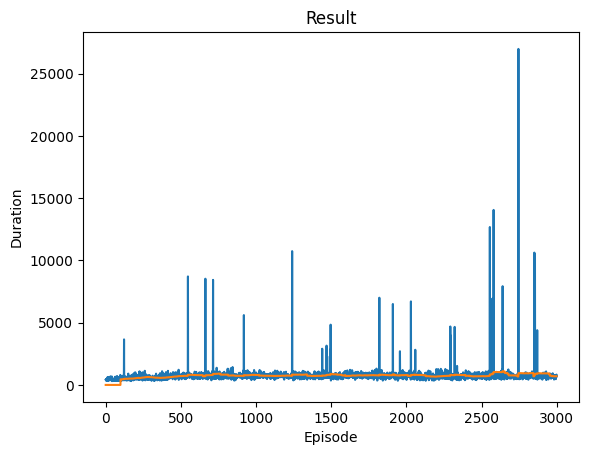

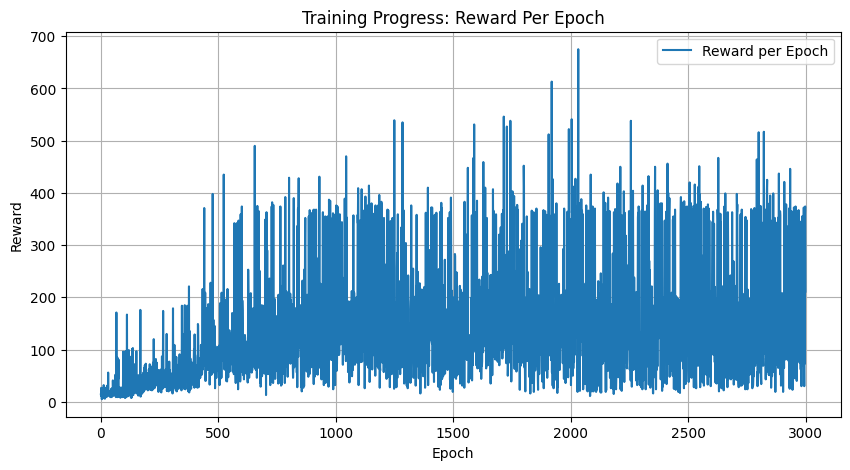

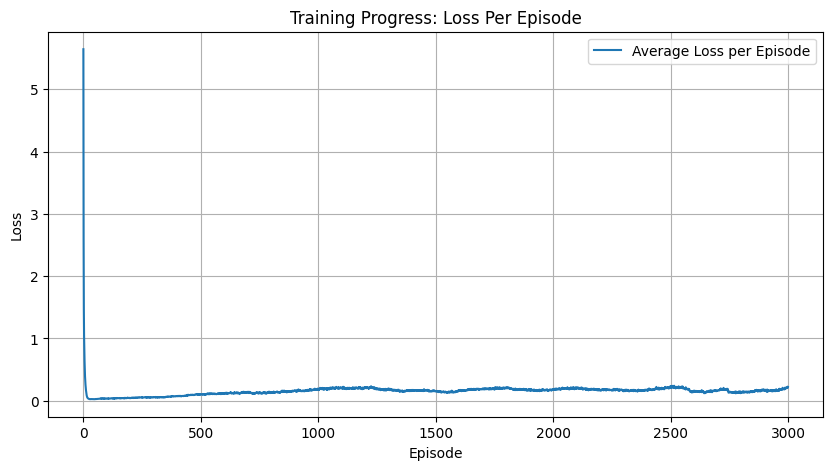

In [46]:
def plot_rewards(rewards):
    rewards = [reward.cpu().item() for reward in rewards]
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.title("Training Progress: Reward Per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(avg_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(avg_losses, label="Average Loss per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Training Progress: Loss Per Episode")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_durations():
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

# Plot rewards
plot_durations()
plot_rewards(rewards)
plot_loss(episode_avg_losses)

# Saving model

In [54]:
# Save the model's state dictionary
torch.save(policy_net.state_dict(), "policy_net_v9_3000e.pth")
torch.save(target_net.state_dict(), "target_net.pth")

# Download and upload to avoid constant training

In [ ]:
from google.colab import files

# Download the files
files.download("policy_net_v4_200e.pth")
files.download("target_net.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

# Upload the model file
uploaded = files.upload() #works for chrome and firefox

# The uploaded file will be saved in the Colab workspace
# Get the filename
filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# Evaluation

C:\Users\misa\AppData\Local\Temp\ipykernel_15260\630447719.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load("policy_net_v9_3000e.pth"))


Episode 1/10: Reward = 364.0
Episode 2/10: Reward = 202.0
Episode 3/10: Reward = 348.0
Episode 4/10: Reward = 355.0
Episode 5/10: Reward = 53.0
Episode 6/10: Reward = 353.0
Episode 7/10: Reward = 372.0
Episode 8/10: Reward = 350.0
Episode 9/10: Reward = 360.0
Episode 10/10: Reward = 367.0
Mean Reward: 312.4
Max Reward: 372.0
Min Reward: 53.0
Standard Deviation: 98.53040139977102


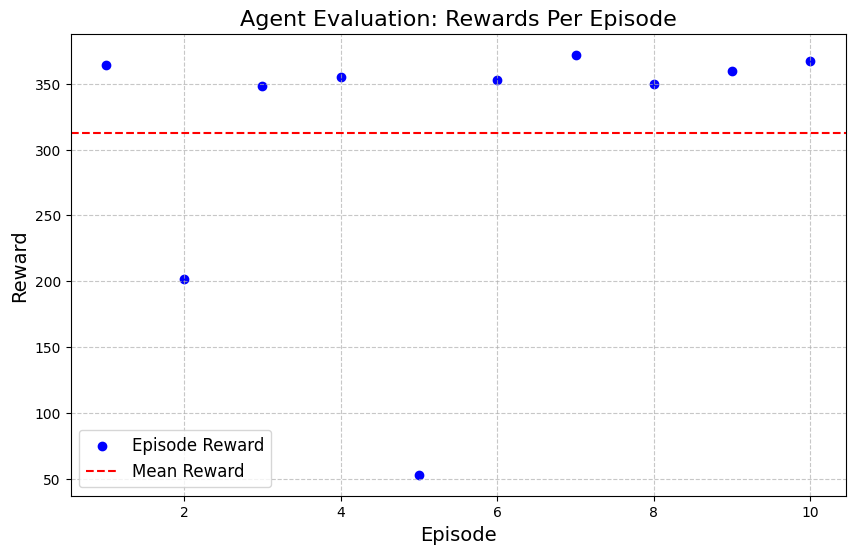

(array([ 12,   0,   0,   0,   6,   0,   0,  19, 255, 255, 254, 255, 255,
        255, 127, 255, 255, 255, 255, 255, 255, 255, 255, 255,   3,   9,
         60,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   9,  76,  76,  76,  76,
         76,  76,  66,  33,  33,  33,  33, 128,   0,   0,   0,   0,  11,
          8,   9,   8,   9,   8,   8,   8,   8,   6,   0, 255,   0,   0,
          0,   0,   0,   0,  64, 160,   0,   0,   0,   0, 254,  78, 254,
          7,   6, 142, 253, 178, 253, 255,   0,   0,  59,   0,   0, 136,
          0,   0,   0,   0,  12,   0,  79, 255,   7,   8, 111,  47,   9,
         87,  15, 251,   4, 251, 248,  53, 105,  52, 211, 247], dtype=uint8),
 {'lives': 4, 'episode_frame_number': 16, 'frame_number': 26555})

In [97]:
import ale_py
import gymnasium as gym
import torch
import os
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

# Create and wrap the environment
gym.register_envs(ale_py)
env = gym.make('ALE/Pacman-ram-v5', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, "videos", episode_trigger=lambda t: True)

# Initialize agent
agent = DQN(n_observations, n_actions).to(device)
agent.load_state_dict(torch.load("policy_net_v9_3000e.pth"))
agent.eval()

# Plotting Function
def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(1, len(rewards) + 1), rewards, color='blue', label='Episode Reward')
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.title("Agent Evaluation: Rewards Per Episode", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(np.mean(rewards), color='red', linestyle='--', label='Mean Reward')  # Add a mean line
    plt.legend(fontsize=12)
    plt.show()

# Evaluate Over Multiple Episodes
n_episodes = 10
rewards = []

for episode in range(n_episodes):
    reward = evaluate_agent(env, agent, device, episode, render=True)
    env.close()
    rewards.append(reward)
    print(f"Episode {episode + 1}/{n_episodes}: Reward = {reward}")

log_metrics(rewards)
plot_rewards(rewards)

# Reset environment for training
env.reset()


# Display video

In [ ]:
!ls videos

In [ ]:
import shutil

shutil.rmtree("videos")

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('videos/episode_7.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)